In [17]:
! pip install pmdarima

  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/40/e5/78afab229ccdaf6b947036440799dbdf88e2cd632e2f96b81f32de8aa05a/pmdarima-2.0.4-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for Cython!=0.29.18,!=0.29.31,>=0.29 from https://files.pythonhosted.org/packages/b6/83/b0a63fc7b315edd46821a1a381d18765c1353d201246da44558175cddd56/Cython-3.0.10-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.0/628.0 kB 6.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.6 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df = pd.read_csv("companies_and_stock_info", parse_dates=["Date"], index_col="Date")
df.head()

,company_name,Open,High,Low,Close,Adj Close,Volume,MACD,Signal Line
Date,,,,,,,,,
2005-01-03,apple,1.156786,1.162679,1.117857,1.130179,0.956809,691992000,0.000000,0.000000
2005-01-04,apple,1.139107,1.169107,1.124464,1.141786,0.966635,1096810400,0.000220,0.000122
2005-01-05,apple,1.151071,1.165179,1.143750,1.151786,0.975101,680433600,0.000543,0.000295
2005-01-06,apple,1.154821,1.159107,1.130893,1.152679,0.975858,705555200,0.000704,0.000434
2005-01-07,apple,1.160714,1.243393,1.156250,1.236607,1.046911,2227450400,0.003604,0.001377


In [3]:
df["company_name"].unique()

array(['apple', 'microsoft', 'google', 'jpmc', 'boa', 'wfc', 'jnj',
       'pfizer', 'merck', 'exxon', 'chevron', 'facebook', 'verizon',
       'atnt'], dtype=object)

In [4]:
print('ANY NULL VALUES---\n',df.isnull().sum(axis = 0))

ANY NULL VALUES---
 company_name    0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
MACD            0
Signal Line     0
dtype: int64


In [5]:
# Define a dictionary mapping each company to its sector
sector_mapping = {
    'apple': 'Technology',
    'microsoft': 'Technology',
    'google': 'Technology',
    'jpmc': 'Finance',
    'boa': 'Finance',
    'wfc': 'Finance',
    'jnj': 'Healthcare',
    'pfizer': 'Healthcare',
    'merck': 'Healthcare',
    'exxon': 'Energy',
    'chevron': 'Energy',
    'facebook': 'Communication',
    'verizon': 'Communication',
    'atnt': 'Communication'
}

df['Sector'] = df['company_name'].map(sector_mapping)

df.head()

,company_name,Open,High,Low,Close,Adj Close,Volume,MACD,Signal Line,Sector
Date,,,,,,,,,,
2005-01-03,apple,1.156786,1.162679,1.117857,1.130179,0.956809,691992000,0.000000,0.000000,Technology
2005-01-04,apple,1.139107,1.169107,1.124464,1.141786,0.966635,1096810400,0.000220,0.000122,Technology
2005-01-05,apple,1.151071,1.165179,1.143750,1.151786,0.975101,680433600,0.000543,0.000295,Technology
2005-01-06,apple,1.154821,1.159107,1.130893,1.152679,0.975858,705555200,0.000704,0.000434,Technology
2005-01-07,apple,1.160714,1.243393,1.156250,1.236607,1.046911,2227450400,0.003604,0.001377,Technology


In [6]:
df.columns

Index(['company_name', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'MACD', 'Signal Line', 'Sector'],
      dtype='object')

In [7]:
df.nunique()

company_name       14
Open            30959
High            30916
Low             30959
Close           31594
Adj Close       62073
Volume          63557
MACD            66029
Signal Line     66029
Sector              5
dtype: int64

####  Basic Statistics 

In [8]:
statistics = {
    'Mean': df.mean(numeric_only=True),
    'Median': df.median(numeric_only=True),
    'Standard Deviation': df.std(numeric_only=True)
}

statistics_df = pd.DataFrame(statistics)
statistics_df

,Mean,Median,Standard Deviation
Open,6.372299e+01,4.631250e+01,5.654971e+01
High,6.434341e+01,4.676000e+01,5.714018e+01
Low,6.309623e+01,4.589347e+01,5.597350e+01
Close,6.373471e+01,4.631000e+01,5.657969e+01
Adj Close,5.281323e+01,3.471290e+01,5.672724e+01
Volume,6.353079e+07,2.262917e+07,1.548333e+08
MACD,-1.240202e+00,6.566909e-02,7.471101e+00
Signal Line,-1.239155e+00,6.460009e-02,7.448345e+00


In [34]:
def get_arima_order(df, target):
#     auto_model = auto_arima(df[target], seasonal = False, stepwise=True, suppress_warnings=True)
#     print("Auto ARIMA Model Summary:")
#     print(auto_model.summary())

#     p, d, q = auto_model.order
#     print("From auto arima p d q : {} {} {}".format(p, d, q))
  # grid search
    p=d=q=range(0,4)
    pdq=list(itertools.product(p,d,q))
    min_aic = float('inf')
    order = None
    for param in pdq:
        try:
            mod = ARIMA(df[target], order=param)
            results = mod.fit()
            if results.aic < min_aic:
                min_aic = results.aic
                order = param
            print()
        except Exception as e:
            print(e)
    print(order, min_aic)

/Users/tanavi/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tanavi/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tanavi/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tanavi/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

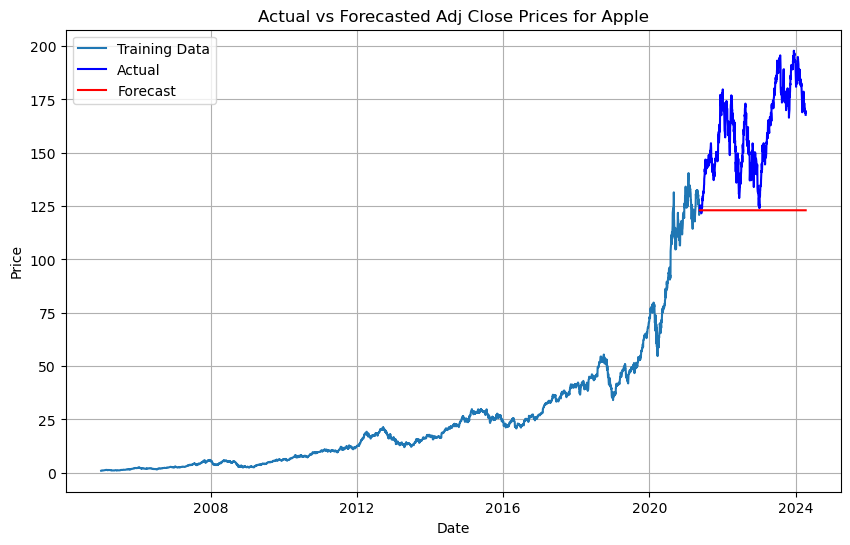

In [32]:
company_data = df[df['company_name'] == 'apple']

series = company_data['Adj Close']

split = int(len(series) * 0.85)
train, test = series[:split], series[split:]

model = ARIMA(train, order=(1,1,0))  # Example order (p, d, q)
model_fit = model.fit()

# Forecast next time points
forecast = model_fit.forecast(steps=len(test))

# Plot actual and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, color='blue', label='Actual')
plt.plot(test.index, forecast, color='red', label='Forecast')
plt.title('Actual vs Forecasted Adj Close Prices for Apple')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
get_arima_order(train, 'Adj Close')

None inf
